In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
matplotlib.rcParams['font.family']= 'ptm' #'Times New Roman'

/var/folders/t4/p3rsq6254flg_bnmk_p_xgkw0000gn/T/ipykernel_68653/2591474775.py:2: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


In [4]:
marginList = [0.07,0.15,0.3]
epsilons = [0.0, 8/255, 16/255, 36/255, 0.3, 0.5, 0.6, 0.8, 1.0]
#index_keep = [0,2,3,4,5,-1]
index_keep = np.arange(len(epsilons))

In [5]:
res = np.zeros((len(marginList),len(epsilons)))

In [6]:
rob_accuracy_Baseline = np.zeros_like(res)
for i, margin in enumerate(marginList):
    rob_accuracy_Baseline[i] = np.loadtxt(f"Baseline ResNet/Cifar10_updateMargin_{margin}.txt")
rob_accuracy_Baseline = rob_accuracy_Baseline[:,index_keep]

In [7]:
res_contractive = np.zeros_like(res)
for i, margin in enumerate(marginList):
    res_contractive[i] = np.loadtxt(f"Contractive/updateMargin_{margin}.txt")
res_contractive = res_contractive[:,index_keep]

In [8]:
rob_accuracy_naive = np.zeros_like(res)
for i, margin in enumerate(marginList):
    rob_accuracy_naive[i] = np.loadtxt(f"NaiveApproach/txtFile_naive_{margin}.txt")

rob_accuracy_naive = rob_accuracy_naive[:,index_keep]

In [9]:
rob_accuracy_switch_prescribed = np.zeros_like(res)
for i, margin in enumerate(marginList):
    rob_accuracy_switch_prescribed[i] = np.loadtxt(f"Switch prescribed/updateMargin_{margin}.txt")

rob_accuracy_switch_prescribed = rob_accuracy_switch_prescribed[:,index_keep]

In [10]:
rob_accuracy_switch_flexible = np.zeros_like(res)
for i, margin in enumerate(marginList):
    rob_accuracy_switch_flexible[i] = np.loadtxt(f"Switch flexible/updateMargin_{margin}.txt")

rob_accuracy_switch_flexible = rob_accuracy_switch_flexible[:,index_keep]

In [11]:
epsilons = np.array(epsilons)[index_keep]

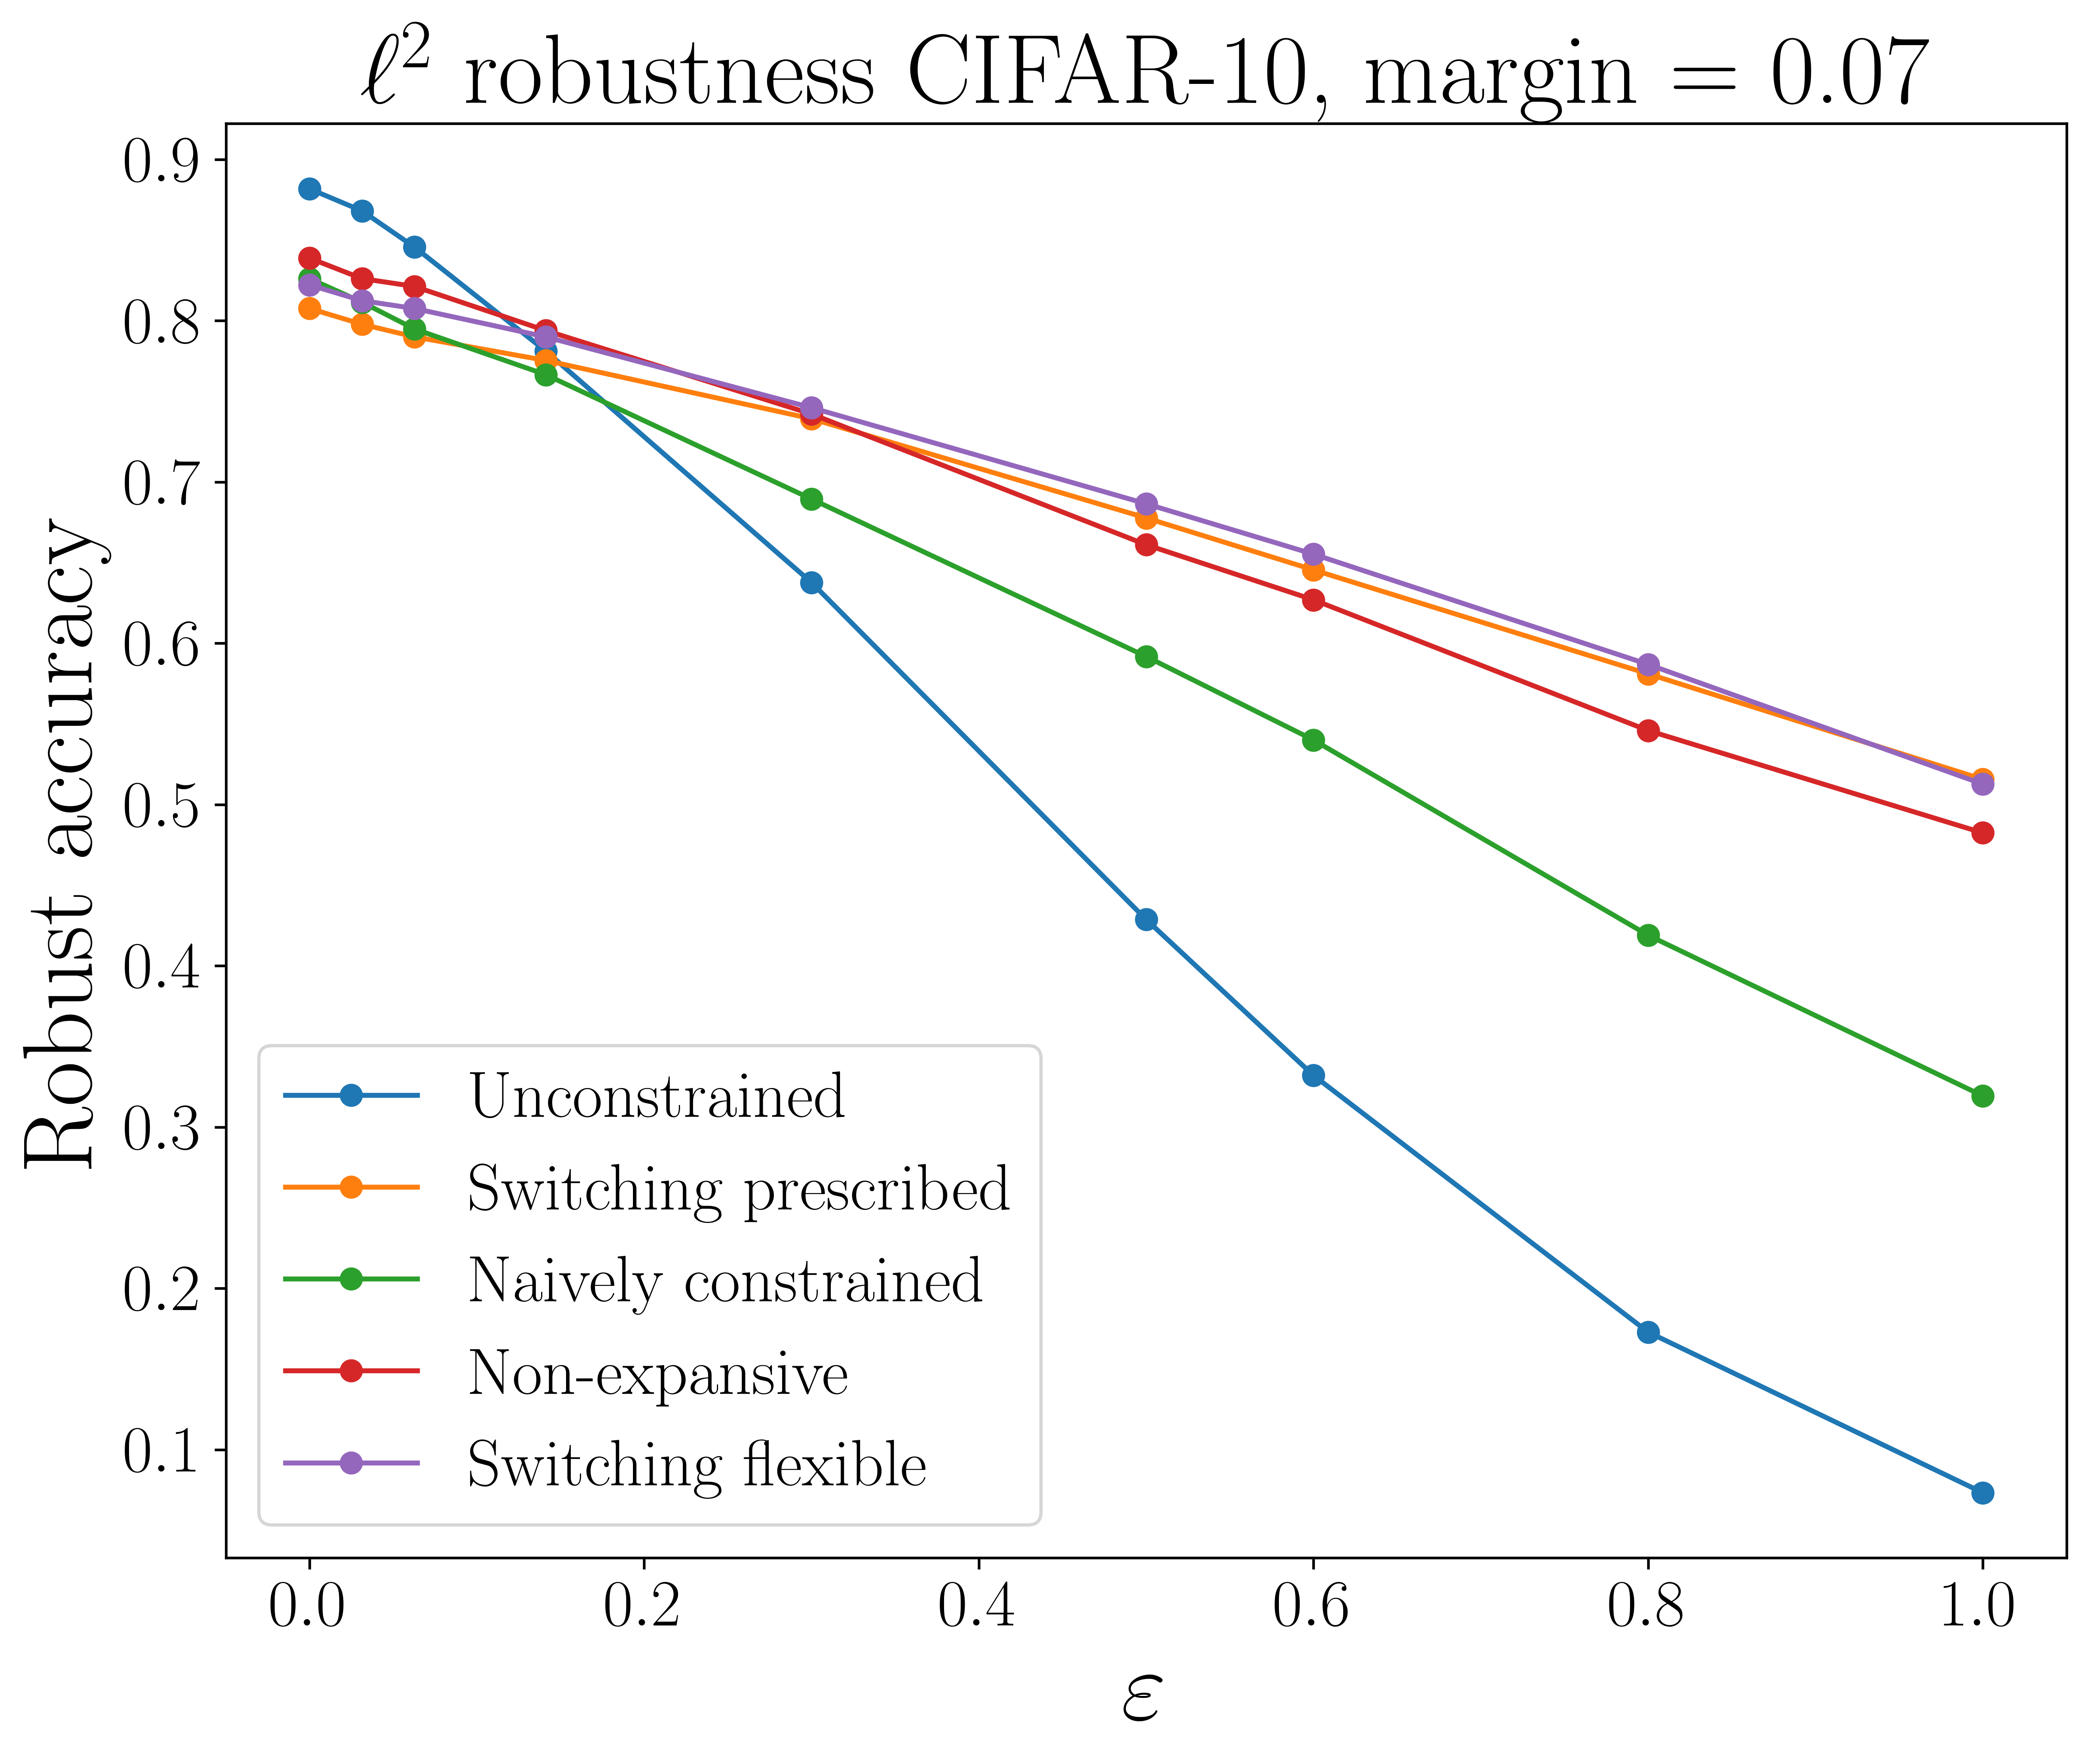

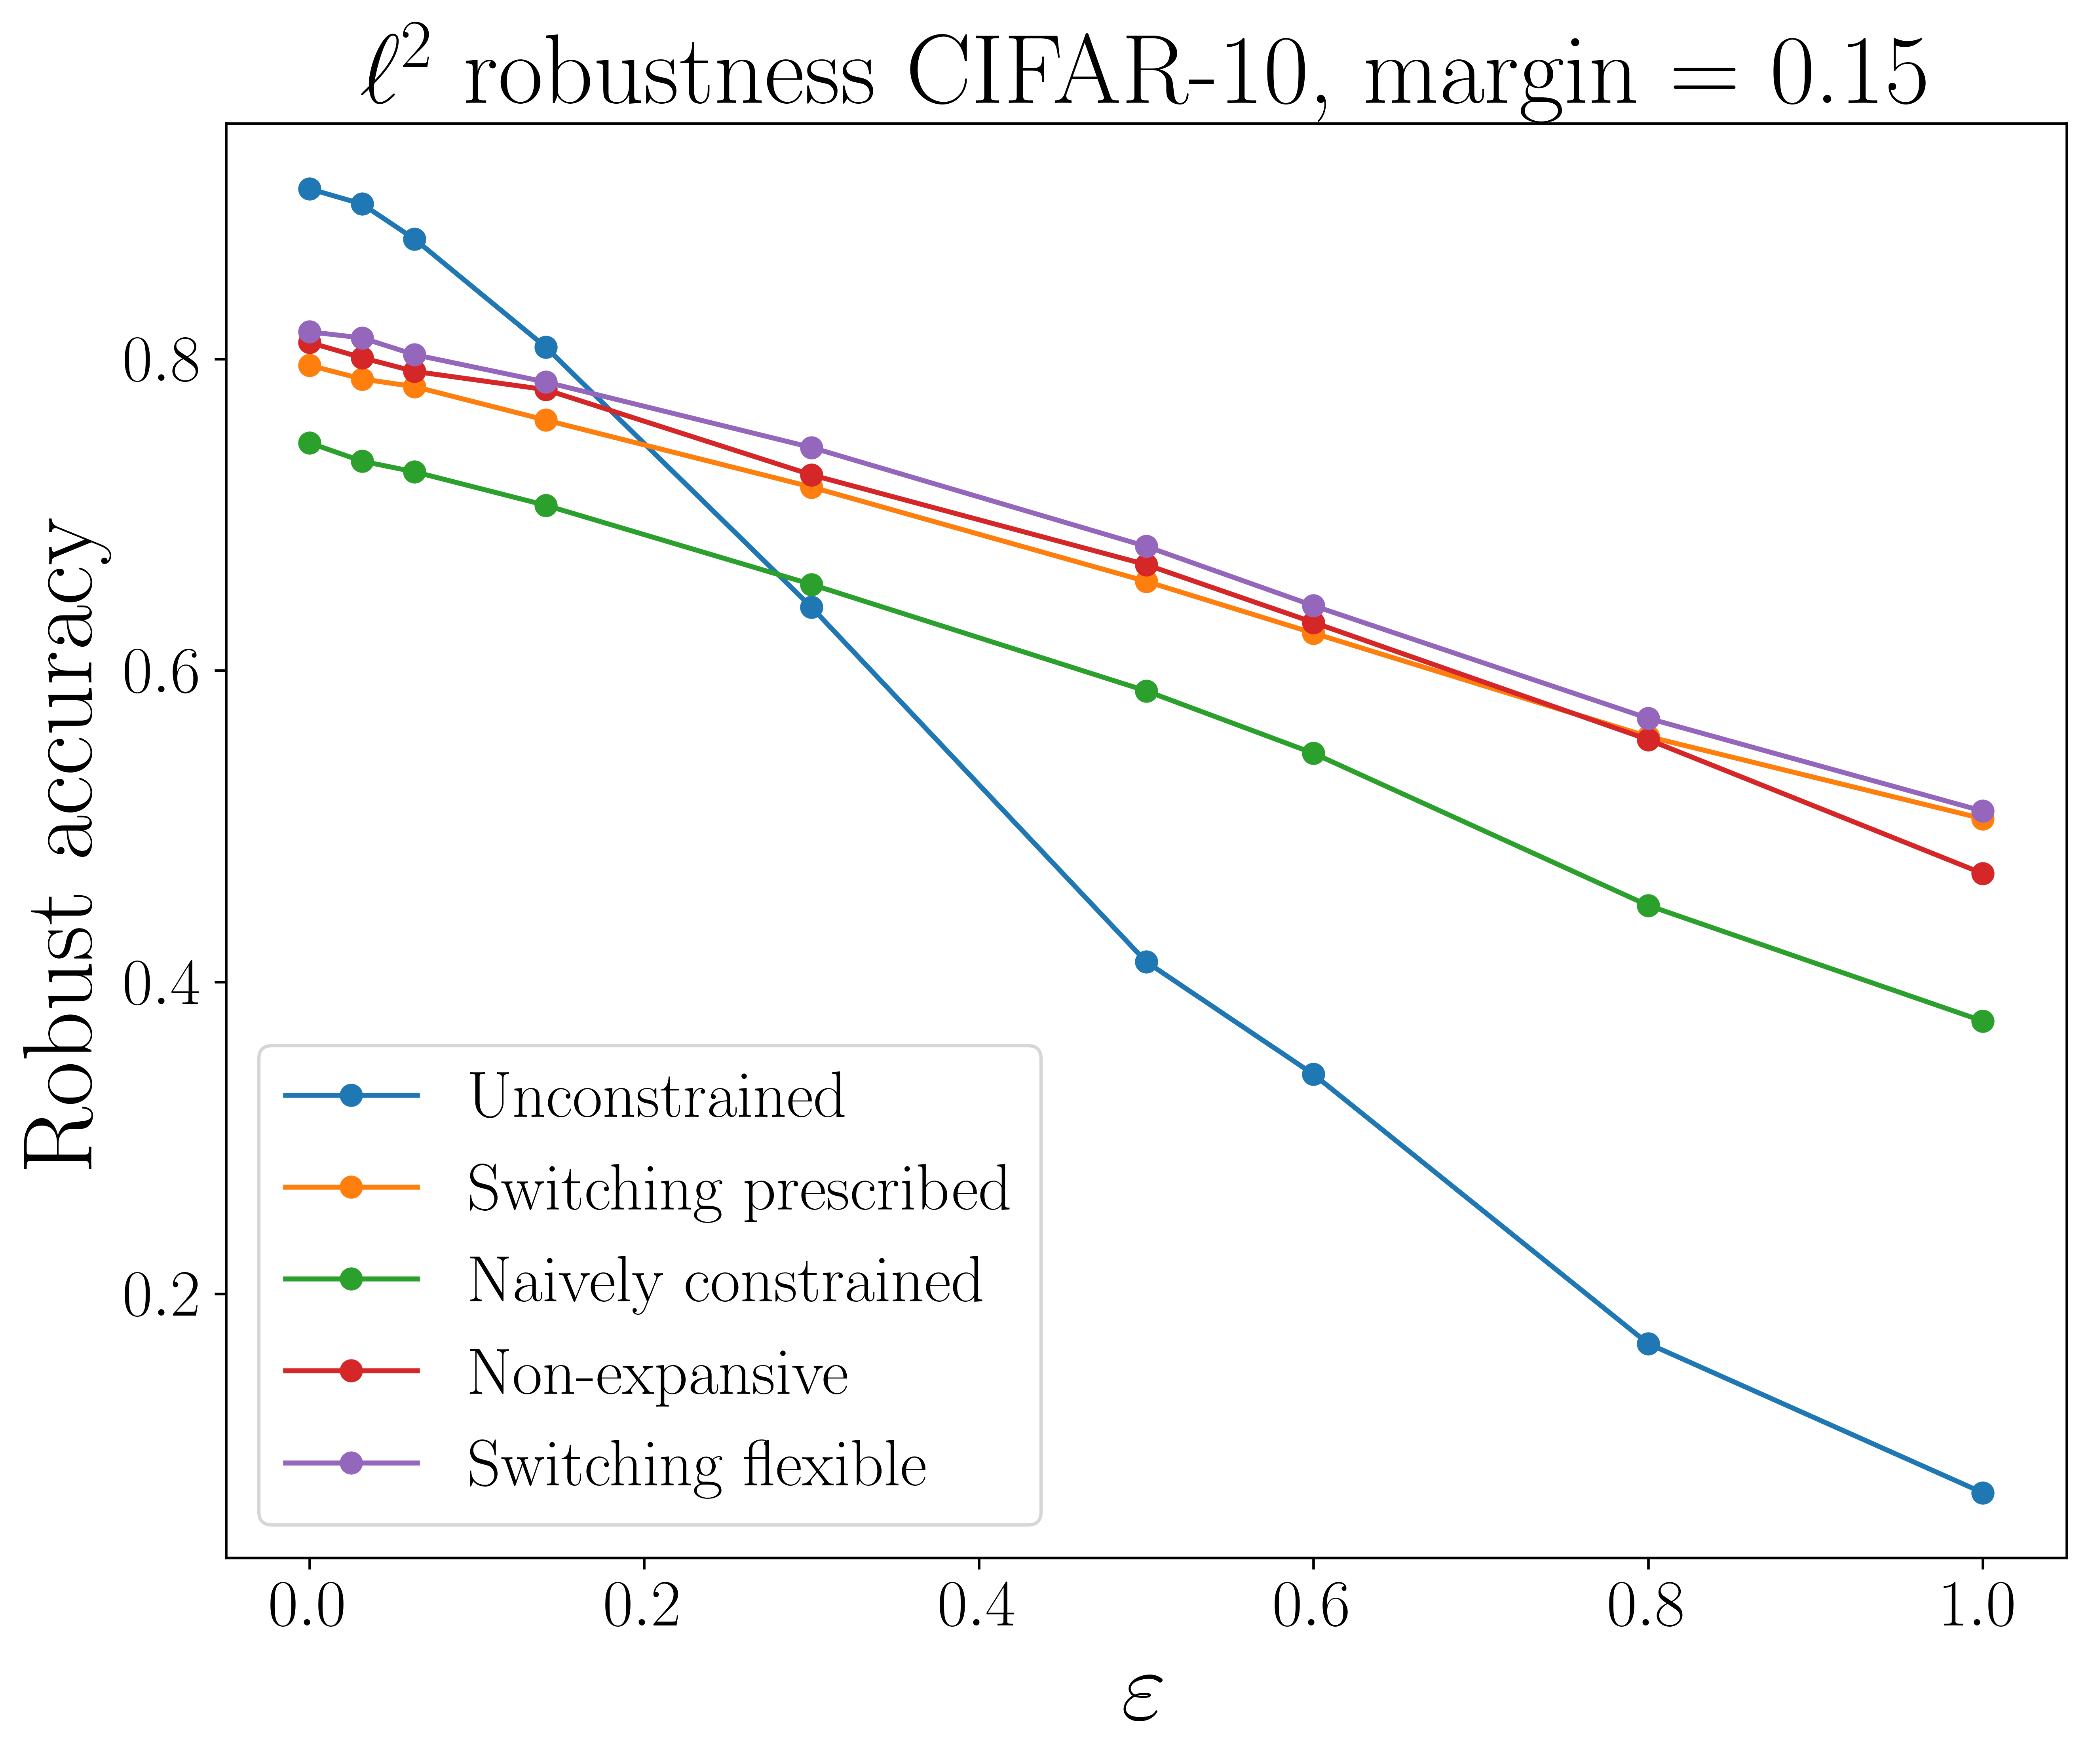

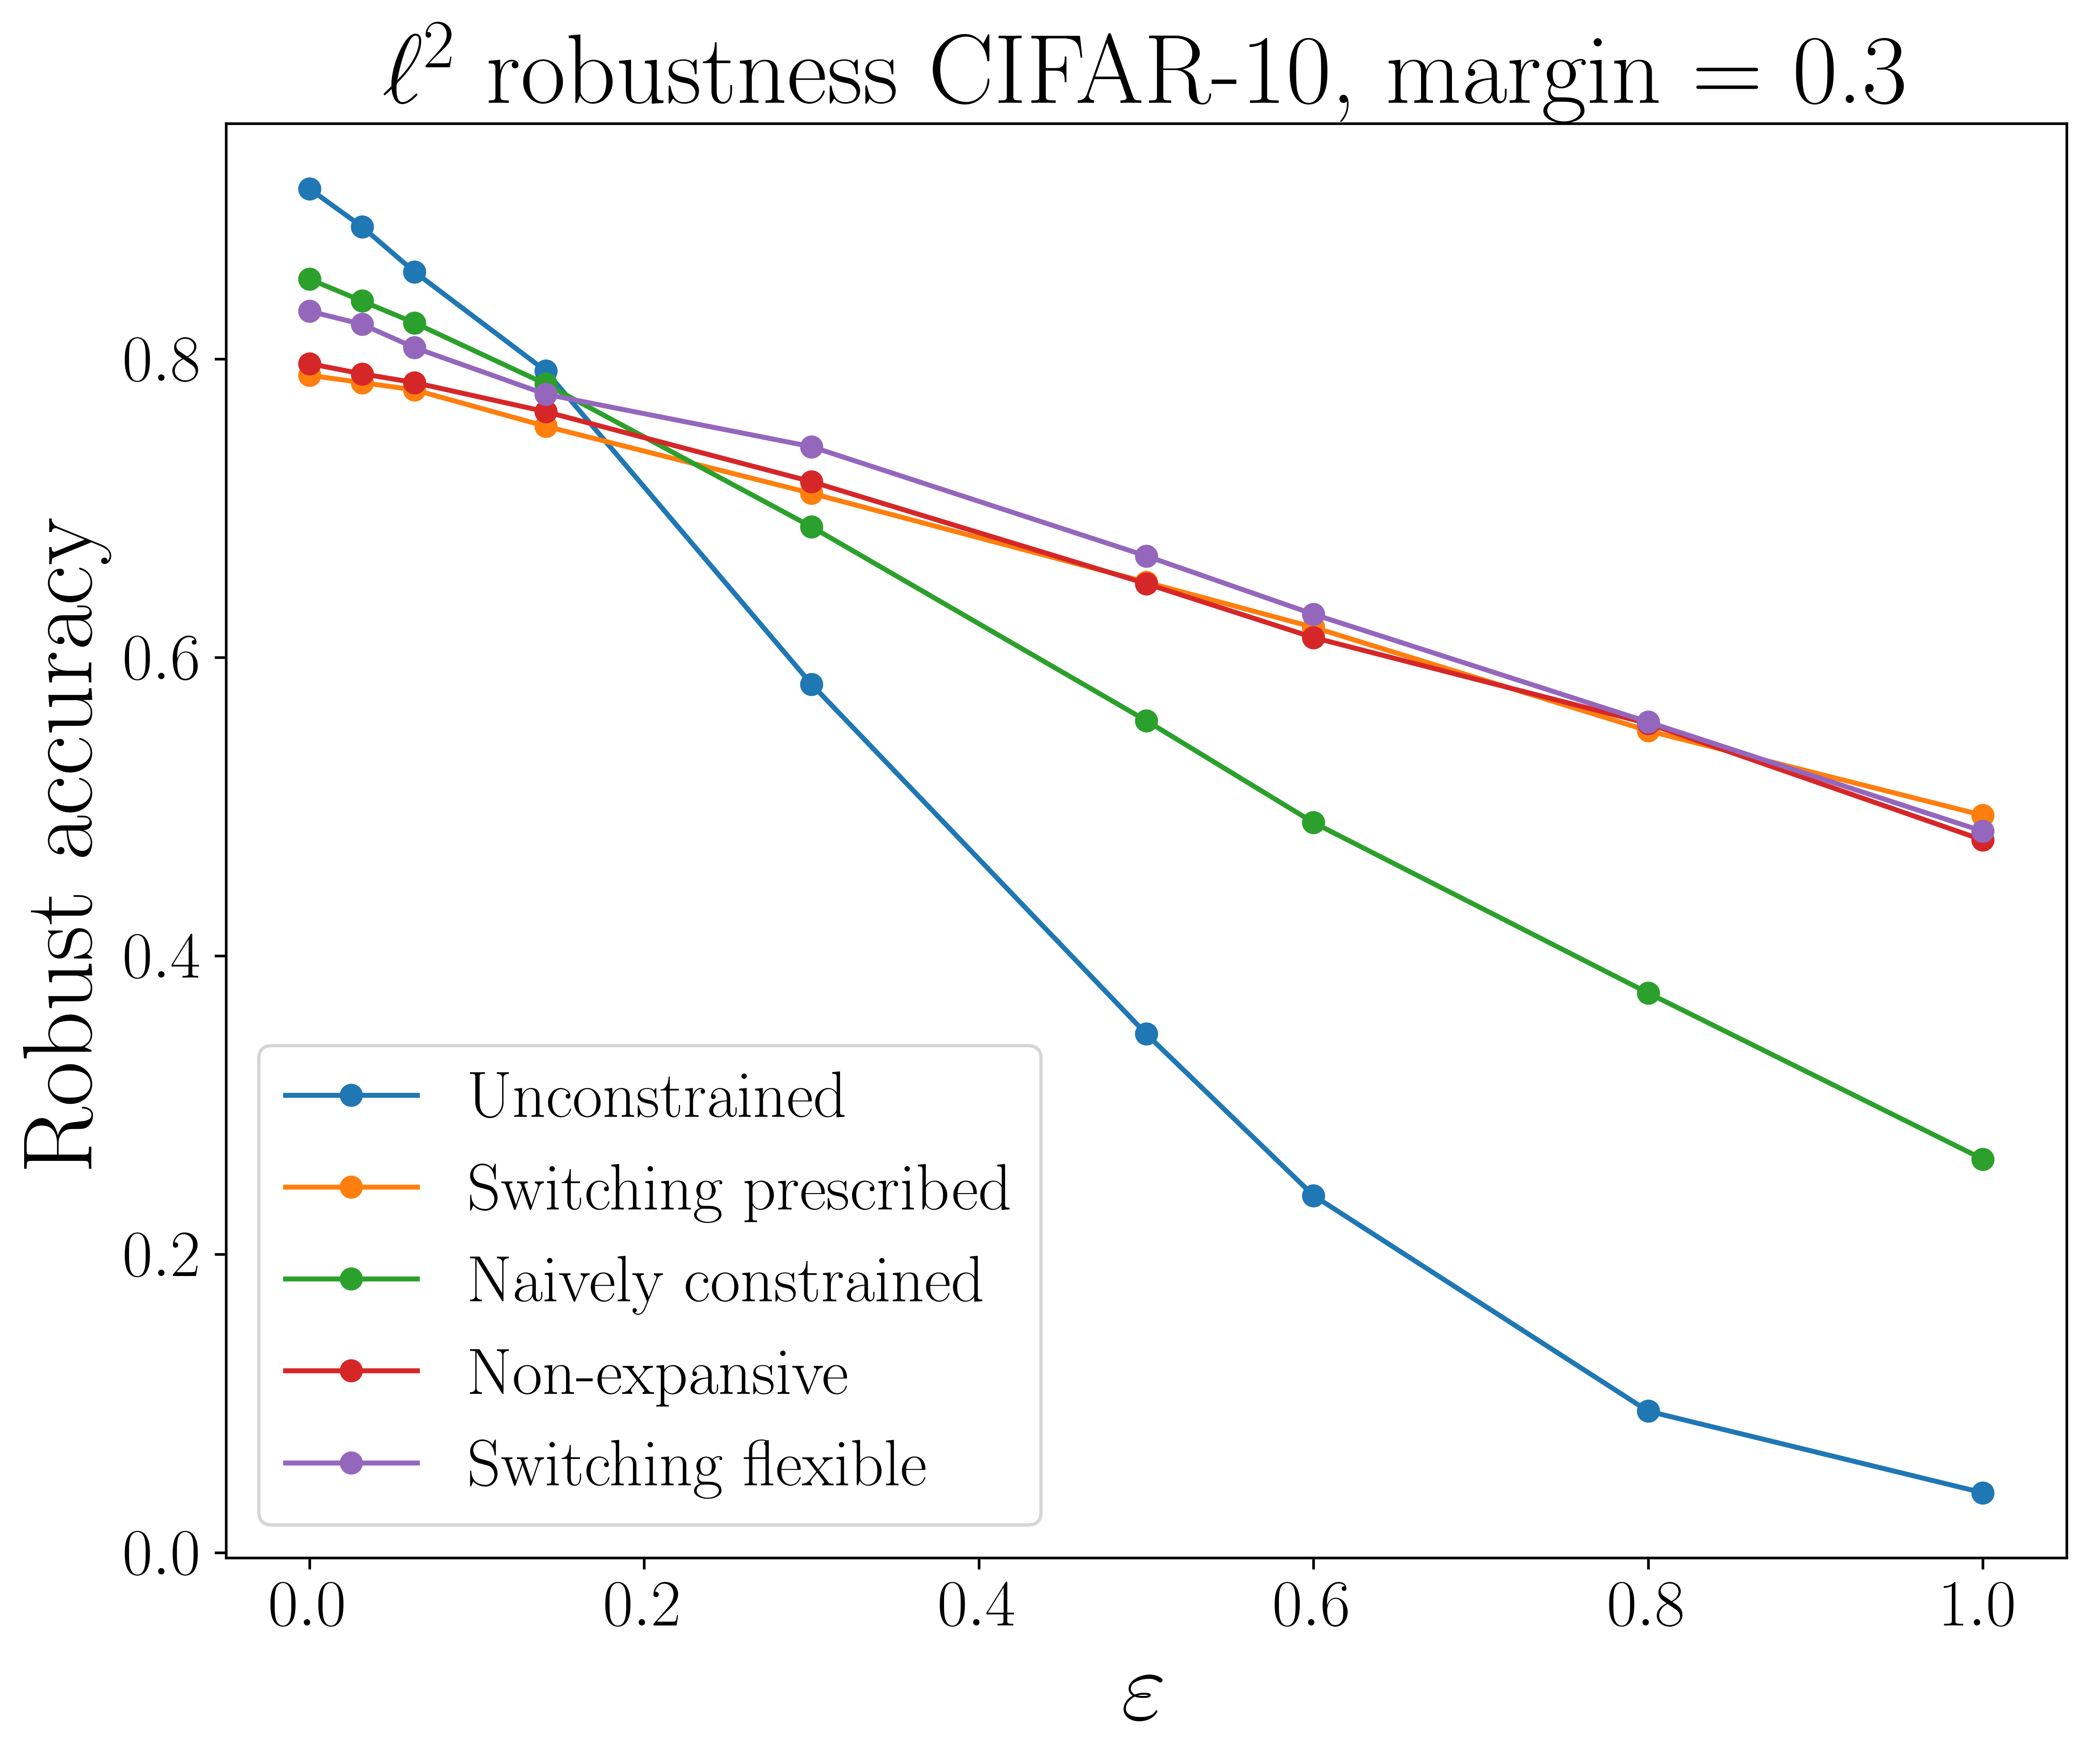

In [12]:
## Plot constrained networks
for i in range(len(marginList)):
    fig = plt.figure(figsize=(10,8),dpi=600)
    plt.plot(epsilons,rob_accuracy_Baseline[i],'-o',label=f"Unconstrained")
    plt.plot(epsilons,rob_accuracy_switch_prescribed[i,index_keep],'-o',label=f"Switching prescribed")
    plt.plot(epsilons,rob_accuracy_naive[i],'-o',label=f"Naively constrained")
    plt.plot(epsilons,res_contractive[i],'-o',label=f"Non-expansive")
    plt.plot(epsilons,rob_accuracy_switch_flexible[i,index_keep],'-o',label=f"Switching flexible")
        
    plt.xlabel(r"$\varepsilon$",fontsize=30)
    plt.ylabel("Robust accuracy",fontsize=30)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20,loc="lower left")

    plt.title(fr"$\ell^2$ robustness CIFAR-10, margin = {marginList[i]}",fontsize=30);
    plt.savefig(f"Robustness_CIFAR10_margin={marginList[i]}.pdf",bbox_inches='tight')
    plt.show()

In [13]:
from pandas import DataFrame as df

In [14]:
names = ["Unconstrained","Naively constrained","Non-expansive","Switching flexible","Switching prescribed"]

matrices = [rob_accuracy_Baseline, 
            rob_accuracy_naive, 
            res_contractive,
            rob_accuracy_switch_flexible,
            rob_accuracy_switch_prescribed]
robustness_dict = {'Margin 0.07' : [matrices[i][0] for i in range(len(matrices))],
                     'Margin 0.15' : [matrices[i][1] for i in range(len(matrices))],
                     'Margin 0.30' : [matrices[i][2] for i in range(len(matrices))]
                     }

In [15]:
total_tensor = df()

total_tensor["Epsilons"] = epsilons

for i in range(len(marginList)):
    for j in range(len(matrices)):
        total_tensor[f"Margin {marginList[i]}, Network {names[j]}"] = matrices[j][i]

In [16]:
def highlight_max(data, color='green'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return df(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

res = total_tensor.iloc[:,1:].style.apply(highlight_max,axis=1)

In [17]:
res

,"Margin 0.07, Network Unconstrained","Margin 0.07, Network Naively constrained","Margin 0.07, Network Non-expansive","Margin 0.07, Network Switching flexible","Margin 0.07, Network Switching prescribed","Margin 0.15, Network Unconstrained","Margin 0.15, Network Naively constrained","Margin 0.15, Network Non-expansive","Margin 0.15, Network Switching flexible","Margin 0.15, Network Switching prescribed","Margin 0.3, Network Unconstrained","Margin 0.3, Network Naively constrained","Margin 0.3, Network Non-expansive","Margin 0.3, Network Switching flexible","Margin 0.3, Network Switching prescribed"
0,0.881836,0.826172,0.838867,0.822266,0.807617,0.909180,0.746094,0.810547,0.817383,0.795898,0.914062,0.853516,0.796875,0.832031,0.789062
1,0.868164,0.811523,0.826172,0.812500,0.797852,0.899414,0.734375,0.800781,0.813477,0.787109,0.888672,0.838867,0.790039,0.823242,0.784180
2,0.845703,0.794922,0.821289,0.807617,0.790039,0.876953,0.727539,0.791992,0.802734,0.782227,0.858398,0.824219,0.784180,0.807617,0.779297
3,0.781250,0.766602,0.793945,0.790039,0.775391,0.807617,0.706055,0.780273,0.785156,0.760742,0.791992,0.783203,0.764648,0.776367,0.754883
4,0.637695,0.689453,0.742188,0.746094,0.739258,0.640625,0.655273,0.725586,0.743164,0.717773,0.582031,0.687500,0.717773,0.741211,0.709961
5,0.428711,0.591797,0.661133,0.686523,0.677734,0.413086,0.586914,0.667969,0.679688,0.657227,0.347656,0.557617,0.649414,0.667969,0.650391
6,0.332031,0.540039,0.626953,0.655273,0.645508,0.340820,0.546875,0.630859,0.641602,0.624023,0.239258,0.489258,0.613281,0.628906,0.620117
7,0.172852,0.418945,0.545898,0.586914,0.581055,0.167969,0.449219,0.555664,0.569336,0.557617,0.094727,0.375000,0.555664,0.556641,0.550781
8,0.073242,0.319336,0.482422,0.512695,0.515625,0.072266,0.375000,0.469727,0.509766,0.504883,0.040039,0.263672,0.477539,0.483398,0.494141


In [18]:
def computeAUC(epsilons,accuracies,normalize=False):
    area = 0.
    for i in range(len(epsilons)-1):
        deps = epsilons[i+1]-epsilons[i]
        area += 0.5 * deps * (accuracies[i]+accuracies[i+1])
    if normalize:
        return area / accuracies[0]
    else:
        return area

In [19]:
matrices = [rob_accuracy_Baseline, 
            rob_accuracy_naive, 
            res_contractive,
            rob_accuracy_switch_flexible,
            rob_accuracy_switch_prescribed]

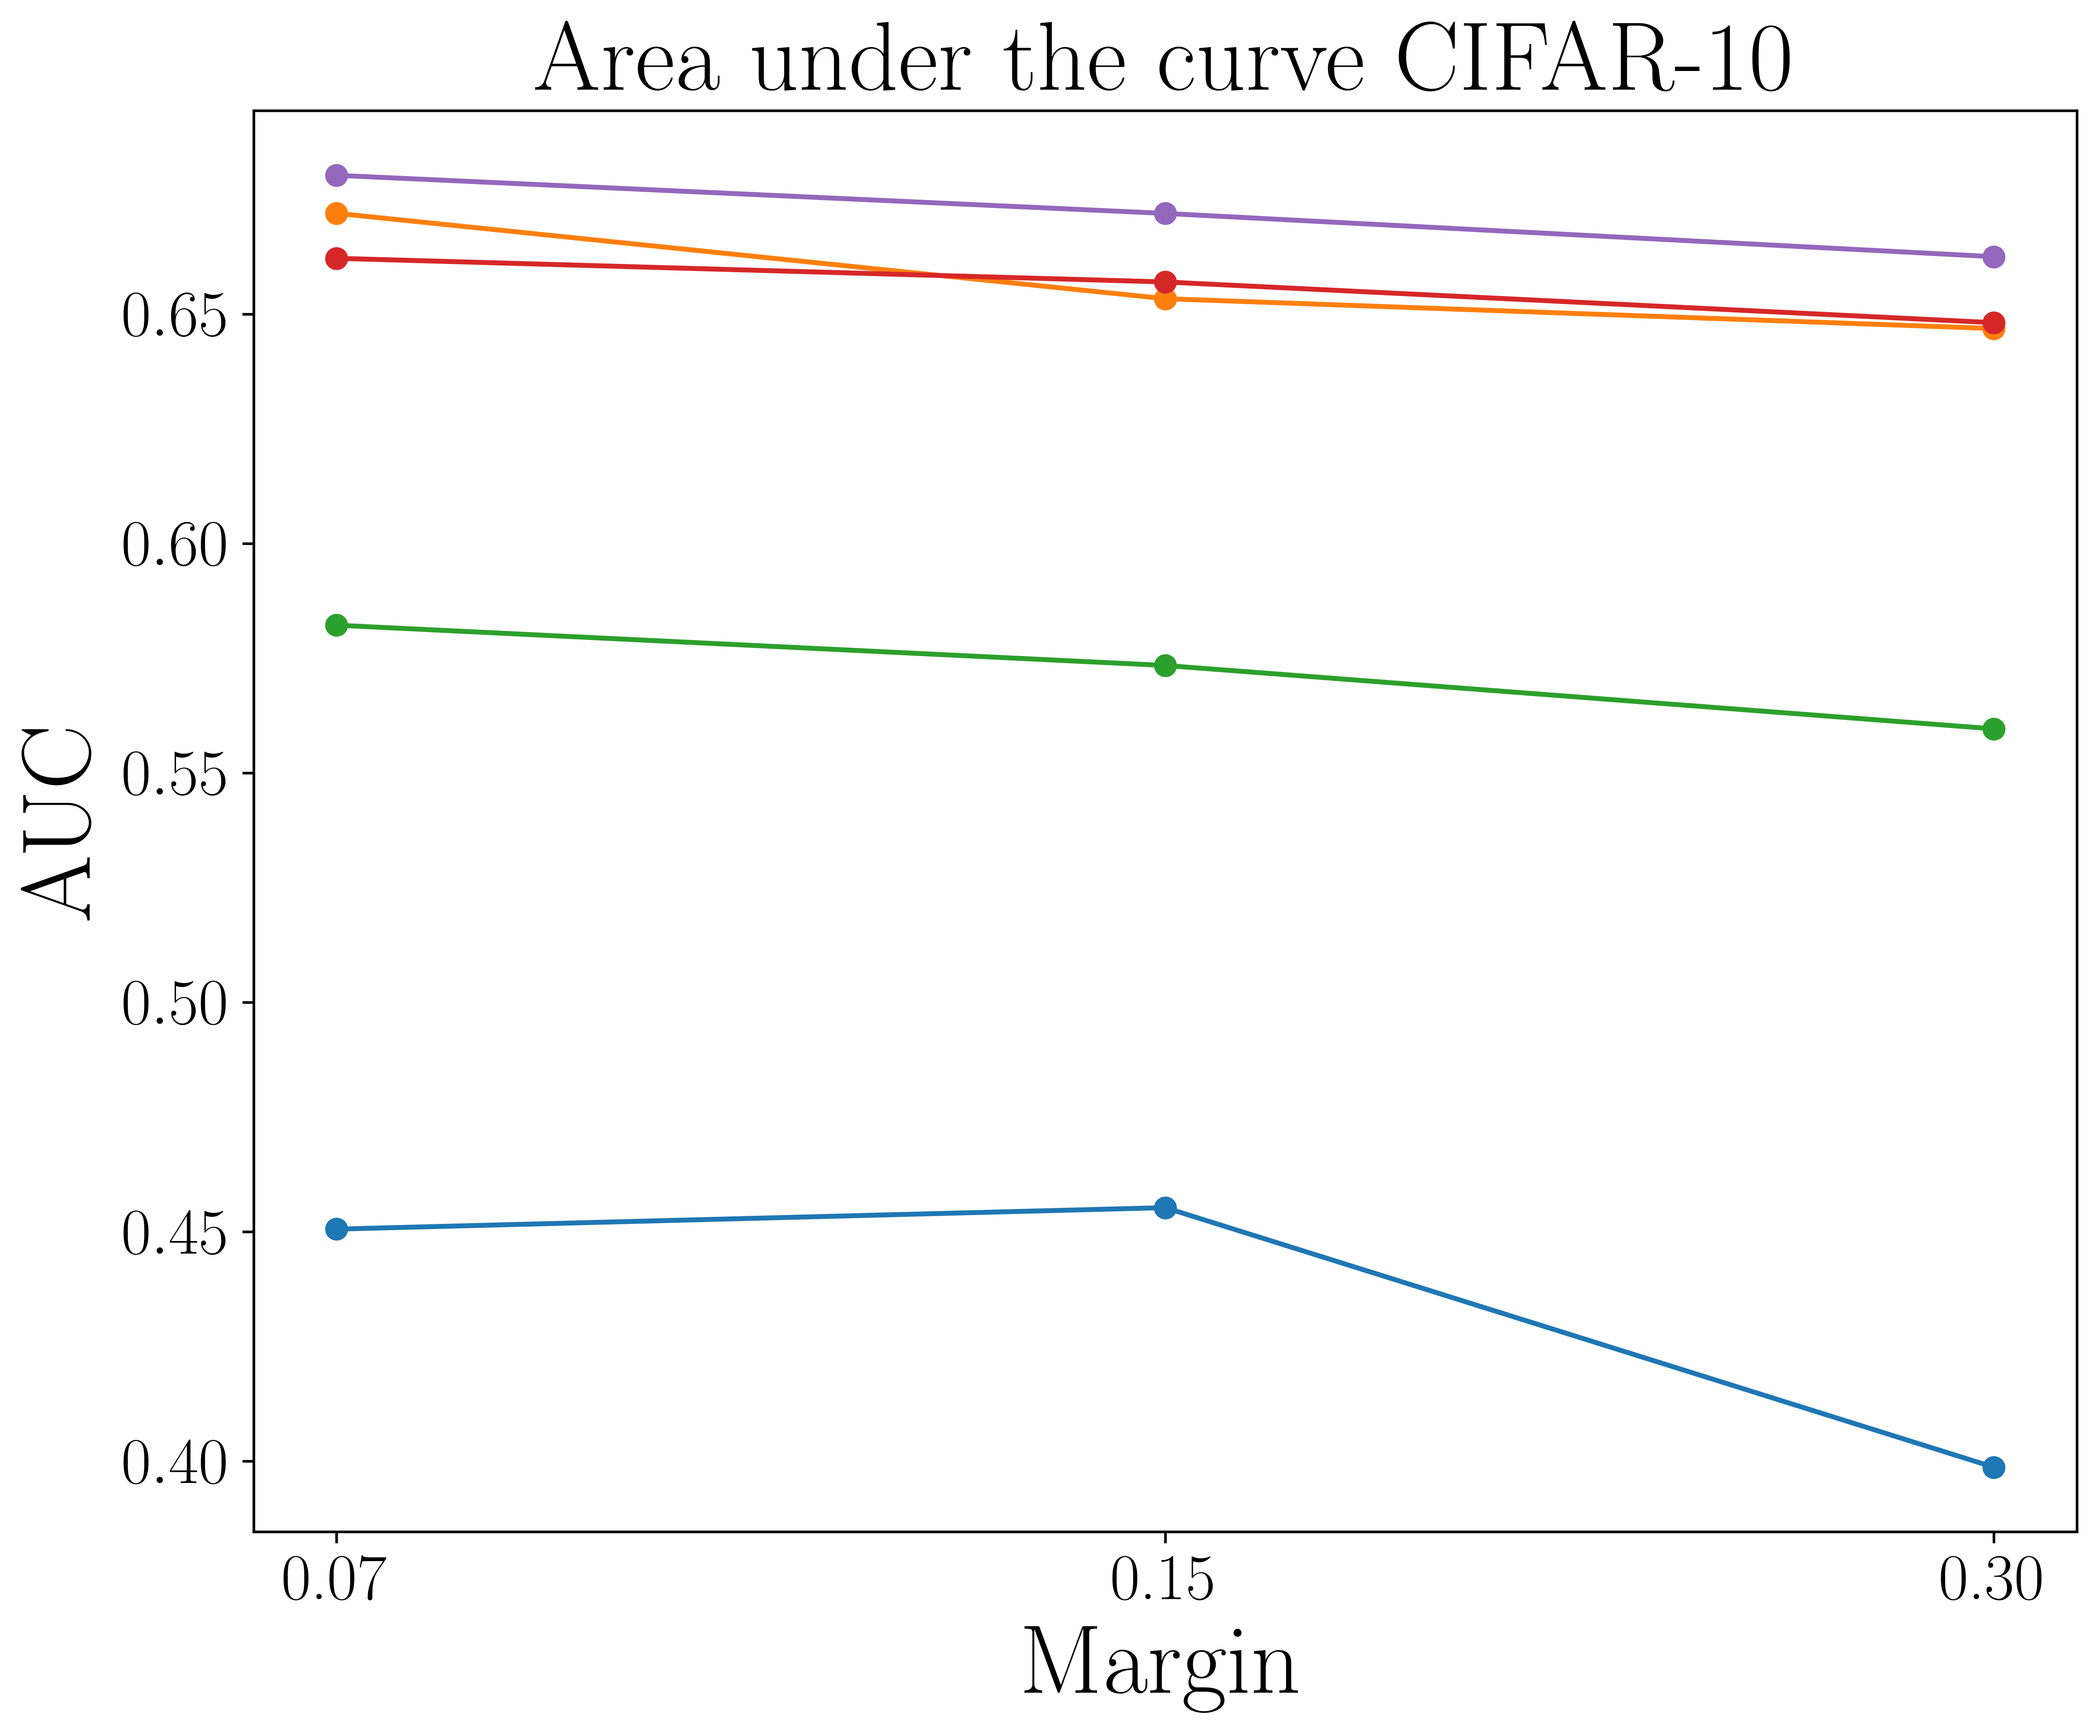

In [20]:
listaBaseline = []
listaPrescribed = []
listaContractive = []
listaFlexible = []
listaNaive = []
for k in range(len(marginList)):
    listaBaseline.append(computeAUC(epsilons,rob_accuracy_Baseline[k]))
    listaPrescribed.append(computeAUC(epsilons,rob_accuracy_switch_prescribed[k]))
    listaNaive.append(computeAUC(epsilons,rob_accuracy_naive[k]))
    listaContractive.append(computeAUC(epsilons,res_contractive[k]))
    listaFlexible.append(computeAUC(epsilons,rob_accuracy_switch_flexible[k]))
    
fig = plt.figure(figsize=(10,8),dpi=600)
plt.plot(listaBaseline,'-o',label="Unconstrained")
plt.plot(listaPrescribed,'-o',label="Switching prescribed")
plt.plot(listaNaive,'-o',label="Naively constrained")
plt.plot(listaContractive,'-o',label="Non-expansive")
plt.plot(listaFlexible,'-o',label="Switching flexible")
plt.xticks([0, 1, 2], ['0.07', '0.15', '0.30'])
plt.xlabel("Margin",fontsize=30)
#plt.legend(fontsize=20)
plt.ylabel("AUC",fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.40),
#          ncol=3, fancybox=True, shadow=True)
plt.title("Area under the curve CIFAR-10",fontsize=30)
plt.savefig("AUC_10.pdf",bbox_inches='tight')
plt.show();